In [0]:
!pip install fastai
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch
!pip install Pillow==4.0.0
!pip install image


# Install the Kaggle API
!pip3 install kaggle


In [0]:
import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline

from fastai.imports import *
from fastai.conv_learner import *

%reload_ext autoreload
%autoreload 2

In [3]:
print("torch.cuda.is_available() : ",torch.cuda.is_available())
print("torch.backends.cudnn.enabled : ", torch.backends.cudnn.enabled)

# Prints the version of PyTorch installed
print(torch.__version__)

# Returns the index of a currently selected device (GPU).
print(torch.cuda.current_device())

# Gets the name of a device
print(torch.cuda.get_device_name(torch.cuda.current_device()))

# The below code works only with PyTorch v 0.4

# Returns the maximum GPU memory usage by tensors in bytes for a given device.
#torch.cuda.max_memory_allocated()

# Returns the current GPU memory usage by tensors in bytes for a given device.
#torch.cuda.memory_allocated(device=torch.cuda.current_device())

torch.cuda.is_available() :  True
torch.backends.cudnn.enabled :  True
0.3.0.post4
0
Tesla K80


# >>>>> PLEASE MODIFY THE FOLLOWING INFO >>>>>
You should enter your own kaggle credentials here

In [0]:
# Set Environment Variables for Kaggle CLI to use

os.environ["KAGGLE_USERNAME"] = 'your_kaggle_username'
os.environ["KAGGLE_KEY"] = 'your_kaggle_key'

In [5]:
# List the competetion data/files
!kaggle competitions files -c rsna-pneumonia-detection-challenge

name                                  size  creationDate         
-----------------------------------  -----  -------------------  
GCP Credits Request Link - RSNA.txt    55B  2018-08-27 12:32:43  
stage_1_detailed_class_info.csv        2MB  2018-08-27 12:32:54  
stage_1_sample_submission.csv         52KB  2018-08-27 12:32:54  
stage_1_train_labels.csv               1MB  2018-08-27 12:32:54  
stage_1_test_images.zip              126MB  2018-08-27 12:32:55  
stage_1_train_images.zip               3GB  2018-08-27 12:32:55  


In [6]:
# Download files from kaggle

# -c: competition name# -c: c 
# -f: which file you want to download
# -p: path to where the file should be saved
!kaggle competitions download -c rsna-pneumonia-detection-challenge -p data/RSNA/

  0% 0.00/55.0 [00:00<?, ?B/s]
100% 55.0/55.0 [00:00<00:00, 41.9kB/s]
  0% 0.00/561k [00:00<?, ?B/s]
100% 561k/561k [00:00<00:00, 83.4MB/s]
  0% 0.00/51.8k [00:00<?, ?B/s]
100% 51.8k/51.8k [00:00<00:00, 36.0MB/s]
  0% 0.00/634k [00:00<?, ?B/s]
100% 634k/634k [00:00<00:00, 104MB/s]
100% 126M/126M [00:01<00:00, 55.7MB/s]

100% 3.16G/3.17G [00:50<00:00, 75.3MB/s]
100% 3.17G/3.17G [00:50<00:00, 67.9MB/s]


In [7]:
!ls data/RSNA/

GCP%20Credits%20Request%20Link%20-%20RSNA.txt  stage_1_test_images.zip
stage_1_detailed_class_info.csv.zip	       stage_1_train_images.zip
stage_1_sample_submission.csv		       stage_1_train_labels.csv.zip


In [8]:
!unzip data/RSNA/stage_1_train_labels.csv.zip -d data/RSNA/

!mv data/RSNA/stage_1_train_labels.csv.zip data/RSNA/zipped/

Archive:  data/RSNA/stage_1_train_labels.csv.zip
  inflating: data/RSNA/stage_1_train_labels.csv  
mv: cannot move 'data/RSNA/stage_1_train_labels.csv.zip' to 'data/RSNA/zipped/': Not a directory


In [9]:
!unzip data/RSNA/stage_1_detailed_class_info.csv.zip -d data/RSNA/

!mv data/RSNA/stage_1_detailed_class_info.csv.zip data/RSNA/zipped/

Archive:  data/RSNA/stage_1_detailed_class_info.csv.zip
  inflating: data/RSNA/stage_1_detailed_class_info.csv  
mv: cannot move 'data/RSNA/stage_1_detailed_class_info.csv.zip' to 'data/RSNA/zipped/': Not a directory


In [0]:
# This step takes time

!unzip data/RSNA/stage_1_train_images.zip -d data/RSNA/train/

!mv data/RSNA/stage_1_train_images.zip data/RSNA/zipped/

In [0]:
!unzip data/RSNA/stage_1_test_images.zip -d data/RSNA/test/

!mv data/RSNA/stage_1_test_images.zip data/RSNA/zipped/

# Exploration ...
# Reading CSV Files and other prep

In [24]:
# Reading stage_1_detailed_class_info.csv

class_info = pd.read_csv("data/RSNA/stage_1_detailed_class_info.csv")
class_info.head(2)

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal


In [25]:
# Reading stage_1_train_labels.csv

train_labels = pd.read_csv("data/RSNA/stage_1_train_labels.csv")
train_labels.head(2)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0


In [26]:
# Filtering train labels by Target==1

train_labels[(train_labels.Target == 1)].head(2)

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [0]:
# Duplicates rows in Class Info can be dropped
class_info = class_info.drop_duplicates('patientId').reset_index(drop=True)

In [28]:
# To add Class labels to train labels df Merge the dataframes
labels_w_class = train_labels.merge(class_info, how='inner', on='patientId')

# The resultant dataframe after removing duplicates
labels_w_class.head(2)

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal


In [29]:
labels_w_class['class'].value_counts()

No Lung Opacity / Not Normal    11500
Lung Opacity                     8964
Normal                           8525
Name: class, dtype: int64

# Reading DICOM Files
***Pydicom library is needed to read the DICOM files***

In [30]:
# Install pydicom library

!pip install pydicom

In [0]:
# Import Libraries required to analyze the DICOM files

from functools import partial
from collections import defaultdict
import pydicom
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

np.warnings.filterwarnings('ignore')

### The following method takes a DICOM file name as input and prints the metadata and plots the image using matplotlib

Automatically created module for IPython interactive environment

Filename.........: data/RSNA/train/e852efc0-2665-4804-a9a3-8f4ed7c1cc83.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name...: e852efc0-2665-4804-a9a3-8f4ed7c1cc83, 
Patient id.......: e852efc0-2665-4804-a9a3-8f4ed7c1cc83
Modality.........: CR
Study Date.......: 19010101
Image size.......: 1024 x 1024, 127518 bytes
Pixel spacing....: ['0.139', '0.139']
Slice location...: (missing)


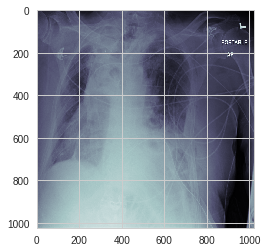

In [32]:
# authors : Guillaume Lemaitre <g.lemaitre58@gmail.com>
# license : MIT

def print_Dicom_File_Details(filename):
  
    import matplotlib.pyplot as plt
    import pydicom
    from pydicom.data import get_testdata_files

    print(__doc__)

    if filename == "":
        print("Printing Sample File and its details...")
        filename = get_testdata_files('CT_small.dcm')[0]

    dataset = pydicom.dcmread(filename)

    # Normal mode:
    print()
    print("Filename.........:", filename)
    print("Storage type.....:", dataset.SOPClassUID)
    print()

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name...:", display_name)
    print("Patient id.......:", dataset.PatientID)
    print("Modality.........:", dataset.Modality)
    print("Study Date.......:", dataset.StudyDate)

    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

    # use .get() if not sure the item exists, and want a default value if missing
    print("Slice location...:", dataset.get('SliceLocation', "(missing)"))

    # plot the image using matplotlib
    plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
    plt.show()
    
    
# Invoking the function for test
print_Dicom_File_Details('data/RSNA/train/e852efc0-2665-4804-a9a3-8f4ed7c1cc83.dcm')

# DICOM (Digital Imaging and Communications in Medicine)

Each Dicom file has two main sections:
1. **Header**: It has t he metadata in text format.
2. **Image**: Stored as pixels. This is stored as a matrix.

One DICOM file is one "Slice" of the organ (2-D). Sometimes me might be given multiple DICOM images per patient all of them in a directory. That consists of multiple slices of the organ being examined. Such a series of DICOM images can be used to create a 3-D model of the organ by stacking them.

### DICOMHeader Information
There are many fields in the header. e.g. PixelSpacing: This has the dimensions [ x , y ] of a
pixel in millimeters (mm): ['0.14300000000000002', '0.14300000000000002']

(group, element) **name** code **value**

(0008, 0005) **Specific Character Set**              CS: **'ISO_IR 100'**

![DICOM File Format](http://dicom.nema.org/dicom/2013/output/chtml/part10/figures/PS3.10_7-1.svg)

## Parse Metadata from DICOM
More details regarding DICOM Image format:
https://www.leadtools.com/sdk/medical/dicom-spec
http://dicom.nema.org/dicom/2013/output/chtml/part10/chapter_7.html

More details regarding Pydicom Library:
https://pydicom.github.io/pydicom/stable/auto_examples/index.html

In [0]:
# Create "Lists" of all train/test dicom filepaths
# Examples: 
# train_dcm_fps[0] = 'data/RSNA/train/adc2cce9-624a-4be6-80f4-de648737f6e4.dcm'
# test_dcm_fps[0] = 'data/RSNA/test/2b885980-3f3c-452f-9ca6-af215dbfe61c.dcm'

# glob – Filename pattern matching
# Purpose:	Use Unix shell rules to fine filenames matching a pattern.
# If you need a list of filenames that all have a certain extension, prefix, 
# or any common string in the middle, use glob instead of 
# writing code to scan the directory contents yourself.

train_dcm_fps = glob.glob('data/RSNA/train/*.dcm')
test_dcm_fps = glob.glob('data/RSNA/test/*.dcm')

In [0]:
# Read the actual DICOM file file into a List
# using stop_before_pixels to avoid reading the image for Speed and Memory Savings
# We are trying to extract the metadata only in this step to create tabular data for analysis

train_dcms = [pydicom.read_file(x, stop_before_pixels=True) for x in train_dcm_fps]
test_dcms = [pydicom.read_file(x, stop_before_pixels=True) for x in test_dcm_fps]

In [35]:
# A sample train record
train_dcms[0]

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.17608.1517874405.102738
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: 'a761a623-c927-4372-a490-46d47a827cd1'
(0010, 0020) Patient ID                          LO: 'a761a623-c927-4372-a490-46d47a827cd1'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

### Method Definition

In [0]:
# Method definition
# This method will be used to print details and Picture of the Dicom Image

def parse_dcm_metadata(dcm):
  
  unpacked_data = {}
  group_elem_to_keywords = {}

  # iterating here to force conversion from lazy RawDataElement to DataElement
  for d in dcm:
    pass
  # keys are pydicom.tag.BaseTag, values are pydicom.dataelem.DataElement
  for tag, elem in dcm.items():
    tag_group = tag.group
    tag_elem = tag.elem
    keyword = elem.keyword
    group_elem_to_keywords[(tag_group, tag_elem)] = keyword
    value = elem.value
    unpacked_data[keyword] = value
    
  return unpacked_data, group_elem_to_keywords

In [0]:
# Method Calls: To parse Train and Test DICOM files
train_meta_dicts, tag_to_keyword_train = zip(*[parse_dcm_metadata(x) for x in train_dcms])
test_meta_dicts, tag_to_keyword_test = zip(*[parse_dcm_metadata(x) for x in test_dcms])

In [38]:
train_meta_dicts[0]

{'AccessionNumber': '',
 'BitsAllocated': 8,
 'BitsStored': 8,
 'BodyPartExamined': 'CHEST',
 'Columns': 1024,
 'ConversionType': 'WSD',
 'HighBit': 7,
 'InstanceNumber': '1',
 'LossyImageCompression': '01',
 'LossyImageCompressionMethod': 'ISO_10918_1',
 'Modality': 'CR',
 'PatientAge': '39',
 'PatientBirthDate': '',
 'PatientID': 'a761a623-c927-4372-a490-46d47a827cd1',
 'PatientName': 'a761a623-c927-4372-a490-46d47a827cd1',
 'PatientOrientation': '',
 'PatientSex': 'F',
 'PhotometricInterpretation': 'MONOCHROME2',
 'PixelRepresentation': 0,
 'PixelSpacing': ['0.168', '0.168'],
 'ReferringPhysicianName': '',
 'Rows': 1024,
 'SOPClassUID': '1.2.840.10008.5.1.4.1.1.7',
 'SOPInstanceUID': '1.2.276.0.7230010.3.1.4.8323329.17608.1517874405.102738',
 'SamplesPerPixel': 1,
 'SeriesDescription': 'view: PA',
 'SeriesInstanceUID': '1.2.276.0.7230010.3.1.3.8323329.17608.1517874405.102736',
 'SeriesNumber': '1',
 'SpecificCharacterSet': 'ISO_IR 100',
 'StudyDate': '19010101',
 'StudyID': '',
 'St

In [39]:
tag_to_keyword_train[0]

{(8, 5): 'SpecificCharacterSet',
 (8, 22): 'SOPClassUID',
 (8, 24): 'SOPInstanceUID',
 (8, 32): 'StudyDate',
 (8, 48): 'StudyTime',
 (8, 80): 'AccessionNumber',
 (8, 96): 'Modality',
 (8, 100): 'ConversionType',
 (8, 144): 'ReferringPhysicianName',
 (8, 4158): 'SeriesDescription',
 (16, 16): 'PatientName',
 (16, 32): 'PatientID',
 (16, 48): 'PatientBirthDate',
 (16, 64): 'PatientSex',
 (16, 4112): 'PatientAge',
 (24, 21): 'BodyPartExamined',
 (24, 20737): 'ViewPosition',
 (32, 13): 'StudyInstanceUID',
 (32, 14): 'SeriesInstanceUID',
 (32, 16): 'StudyID',
 (32, 17): 'SeriesNumber',
 (32, 19): 'InstanceNumber',
 (32, 32): 'PatientOrientation',
 (40, 2): 'SamplesPerPixel',
 (40, 4): 'PhotometricInterpretation',
 (40, 16): 'Rows',
 (40, 17): 'Columns',
 (40, 48): 'PixelSpacing',
 (40, 256): 'BitsAllocated',
 (40, 257): 'BitsStored',
 (40, 258): 'HighBit',
 (40, 259): 'PixelRepresentation',
 (40, 8464): 'LossyImageCompression',
 (40, 8468): 'LossyImageCompressionMethod'}

In [40]:
# Join all the dictionaries created above.
# We do this to make sure we have all the unique key value pairs available in one single dictionary.
# e.g. if dict[0] = {'k1':'v1', 'k3':'v3'} and dict[1] = {'k1':'v1', 'k2':'v2'}
# the unified_dict = {'k1':'v1', 'k2':'v2', 'k3':'v3'}

unified_tag_to_key_train = {k:v for dict_ in tag_to_keyword_train for k,v in dict_.items()}
unified_tag_to_key_test = {k:v for dict_ in tag_to_keyword_test for k,v in dict_.items()}

# Check to make sure the keys between train and test unified dictionaries are all the same
assert len(set(unified_tag_to_key_test.keys()).symmetric_difference(set(unified_tag_to_key_train.keys()))) == 0

tag_to_key = {**unified_tag_to_key_test, **unified_tag_to_key_train}
tag_to_key

{(8, 5): 'SpecificCharacterSet',
 (8, 22): 'SOPClassUID',
 (8, 24): 'SOPInstanceUID',
 (8, 32): 'StudyDate',
 (8, 48): 'StudyTime',
 (8, 80): 'AccessionNumber',
 (8, 96): 'Modality',
 (8, 100): 'ConversionType',
 (8, 144): 'ReferringPhysicianName',
 (8, 4158): 'SeriesDescription',
 (16, 16): 'PatientName',
 (16, 32): 'PatientID',
 (16, 48): 'PatientBirthDate',
 (16, 64): 'PatientSex',
 (16, 4112): 'PatientAge',
 (24, 21): 'BodyPartExamined',
 (24, 20737): 'ViewPosition',
 (32, 13): 'StudyInstanceUID',
 (32, 14): 'SeriesInstanceUID',
 (32, 16): 'StudyID',
 (32, 17): 'SeriesNumber',
 (32, 19): 'InstanceNumber',
 (32, 32): 'PatientOrientation',
 (40, 2): 'SamplesPerPixel',
 (40, 4): 'PhotometricInterpretation',
 (40, 16): 'Rows',
 (40, 17): 'Columns',
 (40, 48): 'PixelSpacing',
 (40, 256): 'BitsAllocated',
 (40, 257): 'BitsStored',
 (40, 258): 'HighBit',
 (40, 259): 'PixelRepresentation',
 (40, 8464): 'LossyImageCompression',
 (40, 8468): 'LossyImageCompressionMethod'}

For more info on creating Pandas DataFrames from Lists and Dictionaries (and from_records):

http://pbpython.com/pandas-list-dict.html
![alt text](http://pbpython.com/images/pandas-dataframe-shadow.png)


In [41]:
# using from_records here since some values in the dicts will be iterables and some are constants
train_df = pd.DataFrame.from_records(data=train_meta_dicts)
test_df = pd.DataFrame.from_records(data=test_meta_dicts)
train_df['dataset'] = 'train'
test_df['dataset'] = 'test'
df = pd.concat([train_df, test_df])

df.head(2)

,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ConversionType,HighBit,InstanceNumber,LossyImageCompression,LossyImageCompressionMethod,...,SeriesDescription,SeriesInstanceUID,SeriesNumber,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime,ViewPosition,dataset
0,,8,8,CHEST,1024,WSD,7,1,01,ISO_10918_1,...,view: PA,1.2.276.0.7230010.3.1.3.8323329.17608.15178744...,1,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.17608.15178744...,000000.00,PA,train
1,,8,8,CHEST,1024,WSD,7,1,01,ISO_10918_1,...,view: AP,1.2.276.0.7230010.3.1.3.8323329.22603.15178744...,1,ISO_IR 100,19010101,,1.2.276.0.7230010.3.1.2.8323329.22603.15178744...,000000.00,AP,train


# Cleaning DICOM Metadata and Merging to Tabular Data

In [0]:
# Separating PixelSpacing list to single values
# The field PixelSpacing in df (above) has (list) value like: [0.168, 0.168]
# It needs to be separated to single columns PixelSpacing_x and PixelSpacing_y

df['PixelSpacing_x'] = df['PixelSpacing'].apply(lambda x: x[0])
df['PixelSpacing_y'] = df['PixelSpacing'].apply(lambda x: x[1])
df = df.drop(['PixelSpacing'], axis='columns')

# The assert Statement: When it encounters an assert statement, 
# Python evaluates the accompanying expression, which is hopefully true. 
# If the expression is false, Python raises an AssertionError exception. 
# If the assertion fails, Python uses ArgumentExpression as the argument for the AssertionError.

# The following test proves that x and y are always the same
assert sum(df['PixelSpacing_x'] != df['PixelSpacing_y']) == 0

In [43]:
# ReferringPhysicianName appears to just be empty strings
assert sum(df['ReferringPhysicianName'] != '') == 0

# SeriesDescription appears to be 'view: {}'.format(ViewPosition)
set(df['SeriesDescription'].unique())

# These 2 columns don't have any useful info and can be safely dropped (later)

{'view: AP', 'view: PA'}

Quick Ref: **PA vs AP**

https://www.med-ed.virginia.edu/courses/rad/cxr/technique3chest.html

**Observations:**

1. Many of the fields are identical throughout all the samples (probably little to gain from looking into these)
2. Looks like PatientAge, PatientSex, PixelSpacing, and ViewPosition are the only metadata items with possible value
3. Wide range of ages
4. Small number of different Pixel Spacings (maybe relevant in terms of resolution and specific to certain imaging machines or setups?)
5. Two different view positions: AP, PA


In [44]:
nunique_all = df.aggregate('nunique')
nunique_all

AccessionNumber                    1
BitsAllocated                      1
BitsStored                         1
BodyPartExamined                   1
Columns                            1
ConversionType                     1
HighBit                            1
InstanceNumber                     1
LossyImageCompression              1
LossyImageCompressionMethod        1
Modality                           1
PatientAge                        97
PatientBirthDate                   1
PatientID                      26684
PatientName                    26684
PatientOrientation                 1
PatientSex                         2
PhotometricInterpretation          1
PixelRepresentation                1
ReferringPhysicianName          8711
Rows                               1
SOPClassUID                        1
SOPInstanceUID                 26684
SamplesPerPixel                    1
SeriesDescription                  2
SeriesInstanceUID              26684
SeriesNumber                       1
S

In [0]:
# drop constant cols (ones with no variation in values across rows) and other
df = df.drop(nunique_all[nunique_all == 1].index.tolist() + ['ReferringPhysicianName','SeriesDescription'], axis='columns')

# now that we have a clean metadata dataframe we can merge back to our initial tabular data with target and class info
df = df.merge(labels_w_class, how='left', left_on='PatientID', right_on='patientId')

df['PatientAge'] = df['PatientAge'].astype(int)

In [0]:
# df now has multiple rows for some patients (those with multiple bounding boxes in label_w_class)
# so creating one with no duplicates for patients

#df_deduped = df.drop_duplicates('PatientID', keep='first')

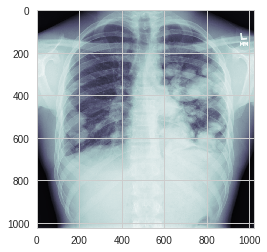

In [47]:
file_dataset = pydicom.dcmread('data/RSNA/train/00322d4d-1c29-4943-afc9-b6754be640eb.dcm')
if 'PixelData' in file_dataset:
    # plot the image using matplotlib
    plt.imshow(file_dataset.pixel_array, cmap=plt.cm.bone)
    plt.show()

In [48]:
print(file_dataset.pixel_array.shape)
file_dataset.pixel_array

(1024, 1024)


array([[  4,  12,  11, ...,  11,  12,   3],
       [ 12,  20,  18, ...,  20,  20,  11],
       [ 10,  18,  17, ...,  19,  19,   9],
       ...,
       [ 15,  28,  29, ...,  69,  88,  53],
       [ 17,  30,  29, ...,  87, 111,  73],
       [  7,  19,  18, ...,  62,  84,  43]], dtype=uint8)

In [50]:
pd.options.display.max_columns = 100
df.head(2)

,PatientAge,PatientID,PatientName,PatientSex,SOPInstanceUID,SeriesInstanceUID,StudyInstanceUID,ViewPosition,dataset,PixelSpacing_x,PixelSpacing_y,patientId,x,y,width,height,Target,class
0,39,a761a623-c927-4372-a490-46d47a827cd1,a761a623-c927-4372-a490-46d47a827cd1,F,1.2.276.0.7230010.3.1.4.8323329.17608.15178744...,1.2.276.0.7230010.3.1.3.8323329.17608.15178744...,1.2.276.0.7230010.3.1.2.8323329.17608.15178744...,PA,train,0.168,0.168,a761a623-c927-4372-a490-46d47a827cd1,NaN,NaN,NaN,NaN,0.0,No Lung Opacity / Not Normal
1,60,65f23305-56dc-4be8-8dae-3593df2cb3e9,65f23305-56dc-4be8-8dae-3593df2cb3e9,M,1.2.276.0.7230010.3.1.4.8323329.22603.15178744...,1.2.276.0.7230010.3.1.3.8323329.22603.15178744...,1.2.276.0.7230010.3.1.2.8323329.22603.15178744...,AP,train,0.168,0.168,65f23305-56dc-4be8-8dae-3593df2cb3e9,NaN,NaN,NaN,NaN,0.0,No Lung Opacity / Not Normal


In [90]:
df['class'].value_counts()

No Lung Opacity / Not Normal    11500
Lung Opacity                     8964
Normal                           8525
Name: class, dtype: int64

## The below method plots the images
It takes the following parameters:

**dataFrm**: Dataframe

**datasetname**: 'train' or 'test' are the possible values

**imgclass**: 'No Lung Opacity / Not Normal'  or  'Lung Opacity' or 'Normal'

**target**: 0 or 1. 0 means no Pneumonia. 1 means Pnemonia.

**numofimages**: Number of images to be printed.

*For more details about the Lung Opacity, go through the following link:*

https://www.kaggle.com/zahaviguy/what-are-lung-opacities

In [0]:
def plot_dicom_image (dataFrm, datasetname, imgclass, target, numofimages):
  
      #patientRecords = dataFrm[(dataFrm["dataset"] == datasetname) & (dataFrm["class"] == imgclass) & (dataFrm["Target"] == target)][:numofimages]
      patientRecords = dataFrm[(dataFrm["dataset"] == datasetname) & (dataFrm["class"] == imgclass) & (dataFrm["Target"] == target)].sample(numofimages)  
      
      plotRows = 0
      if (numofimages > 0):
          if (numofimages % 2 == 0):
              plotRows = int(numofimages / 2)
          else:
              plotRows = int((numofimages + 1) / 2)
      
      plotCols = 2
      pos = 1
      
      plt.figure(figsize=(18,20))
      plt.subplots_adjust(hspace=0, wspace=0.4)
      
      for index, row in patientRecords.iterrows():
          filename = 'data/RSNA/' + datasetname + '/' + row["patientId"] + '.dcm'
    
          dataset = pydicom.dcmread(filename)
    
          im = dataset.pixel_array
    
          # --- Convert from single-channel grayscale to 3-channel RGB
          im = np.stack([im] * 3, axis=2)

          # --- Add boxes with random color if present
          rgb = np.floor([0,255,127]).astype('int')
          stroke=6
          
          dupRecsWithBox = dataFrm[(dataFrm["dataset"] == datasetname) & (dataFrm["class"] == imgclass) & (dataFrm["Target"] == target) & (dataFrm["patientId"] == row["patientId"])]
          
          if len(dupRecsWithBox) > 0:
              for index2, row2 in dupRecsWithBox.iterrows():
                  # --- Extract coordinates if the value of x exists
                  if (False == np.isnan(row2["x"])):
                      y1 = int(row2["y"])
                      x1 = int(row2["x"])
                      height = int(row2["height"])
                      width = int(row2["width"])
                      y2 = y1 + height
                      x2 = x1 + width

                      im[y1:y1 + stroke, x1:x2] = rgb
                      im[y2:y2 + stroke, x1:x2] = rgb
                      im[y1:y2, x1:x1 + stroke] = rgb
                      im[y1:y2, x2:x2 + stroke] = rgb

          plt.subplot(plotRows, plotCols, pos)
          pos = pos + 1
          plt.title("Class: {} | PatientId: {}".format(row2["class"] , row2["patientId"]))
          plt.imshow(im, cmap=plt.cm.gist_gray)
          plt.axis('off')

## View: Normal

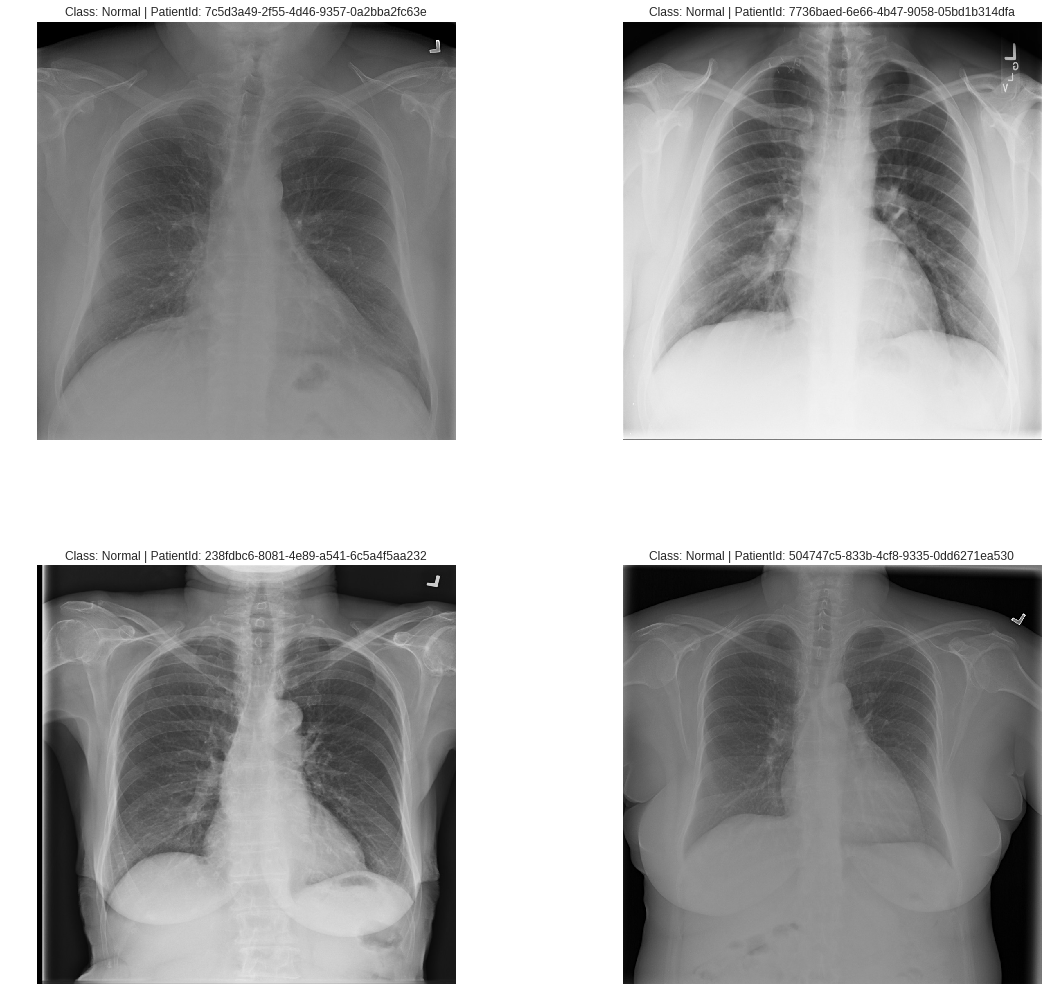

In [140]:
# --- Function call ---
# dataFrm: Dataframe
# datasetname: 'train' or 'test' are the possible values
# imgclass: 'No Lung Opacity / Not Normal' or 'Lung Opacity' or 'Normal'
# target: 0 or 1. 0 means no Pneumonia. 1 means Pnemonia.
# numofimages: Number of images to be printed.

plot_dicom_image (df, datasetname = 'train', imgclass = 'Normal',target = 0, numofimages = 4)

In [54]:
# View the data as a table to understand the parameters passed above

df[(df["dataset"] == 'train') & (df["class"] == 'Lung Opacity') & (df["Target"] == 1)][:2]

,PatientAge,PatientID,PatientName,PatientSex,SOPInstanceUID,SeriesInstanceUID,StudyInstanceUID,ViewPosition,dataset,PixelSpacing_x,PixelSpacing_y,patientId,x,y,width,height,Target,class
11,28,77b4e9ec-9002-444f-b3a5-9e5ab9dacaa5,77b4e9ec-9002-444f-b3a5-9e5ab9dacaa5,F,1.2.276.0.7230010.3.1.4.8323329.24902.15178744...,1.2.276.0.7230010.3.1.3.8323329.24902.15178744...,1.2.276.0.7230010.3.1.2.8323329.24902.15178744...,AP,train,0.168,0.168,77b4e9ec-9002-444f-b3a5-9e5ab9dacaa5,184.0,641.0,161.0,158.0,1.0,Lung Opacity
16,73,835ea6ca-9564-41da-80de-568f18c82ab2,835ea6ca-9564-41da-80de-568f18c82ab2,F,1.2.276.0.7230010.3.1.4.8323329.9757.151787434...,1.2.276.0.7230010.3.1.3.8323329.9757.151787434...,1.2.276.0.7230010.3.1.2.8323329.9757.151787434...,AP,train,0.139,0.139,835ea6ca-9564-41da-80de-568f18c82ab2,584.0,399.0,250.0,318.0,1.0,Lung Opacity


## View: Lung Opacity

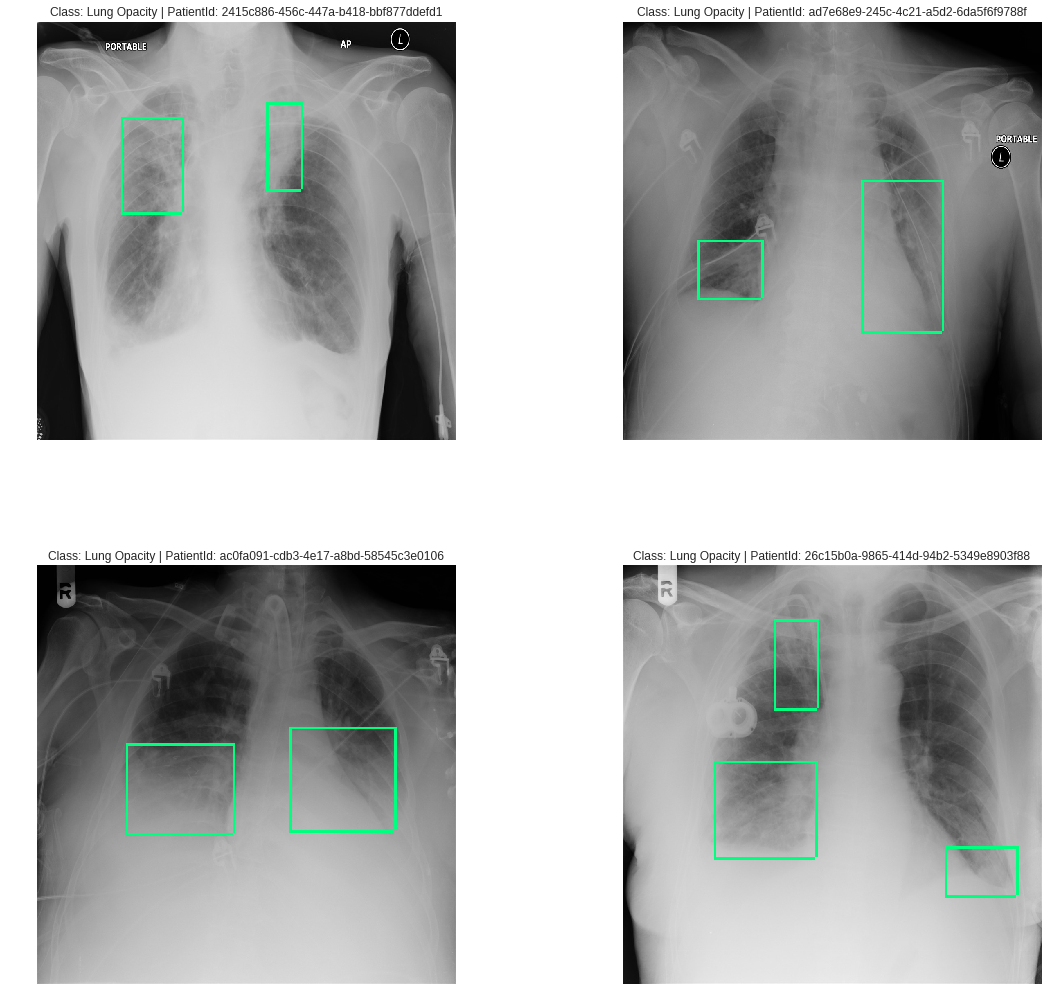

In [141]:
plot_dicom_image (df, datasetname = 'train', imgclass = 'Lung Opacity', target = 1, numofimages = 4)

## View: No Lung Opacity / Not Normal

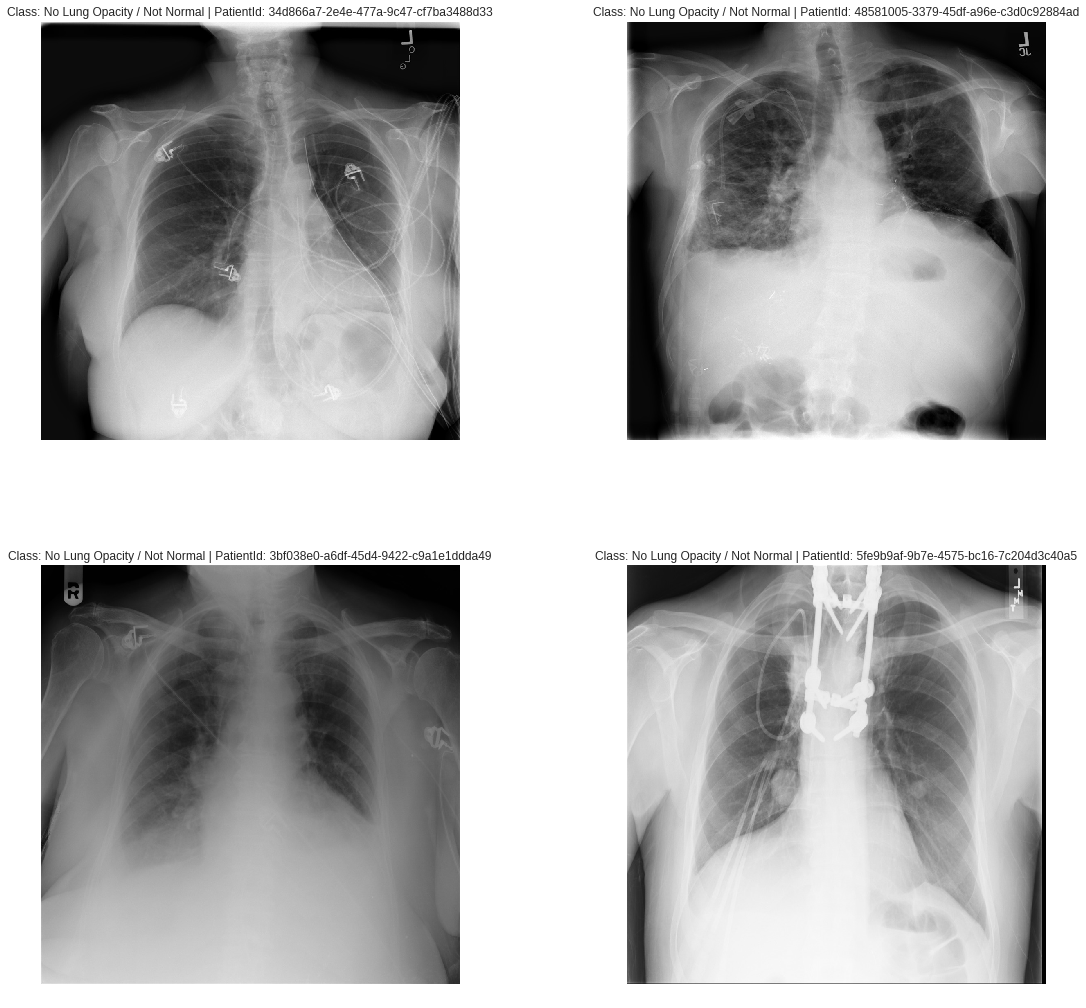

In [139]:
plot_dicom_image (df, datasetname = 'train', imgclass = 'No Lung Opacity / Not Normal', target = 0, numofimages = 4)

Here is a link to the RSNA challenge on Kaggle:

https://www.kaggle.com/c/rsna-pneumonia-detection-challenge

Other references:

https://www.kaggle.com/peterchang77/exploratory-data-analysis
